In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [ ]:
# Brining in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [ ]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteBTRN3Z/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteBTRN3Z/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next()['label']

2

#2. Viz Data and Build Dataset

In [ ]:
# Do some data transformation
import numpy as np

In [ ]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Getting data out of the pipeline
dataiterator.next()['image']

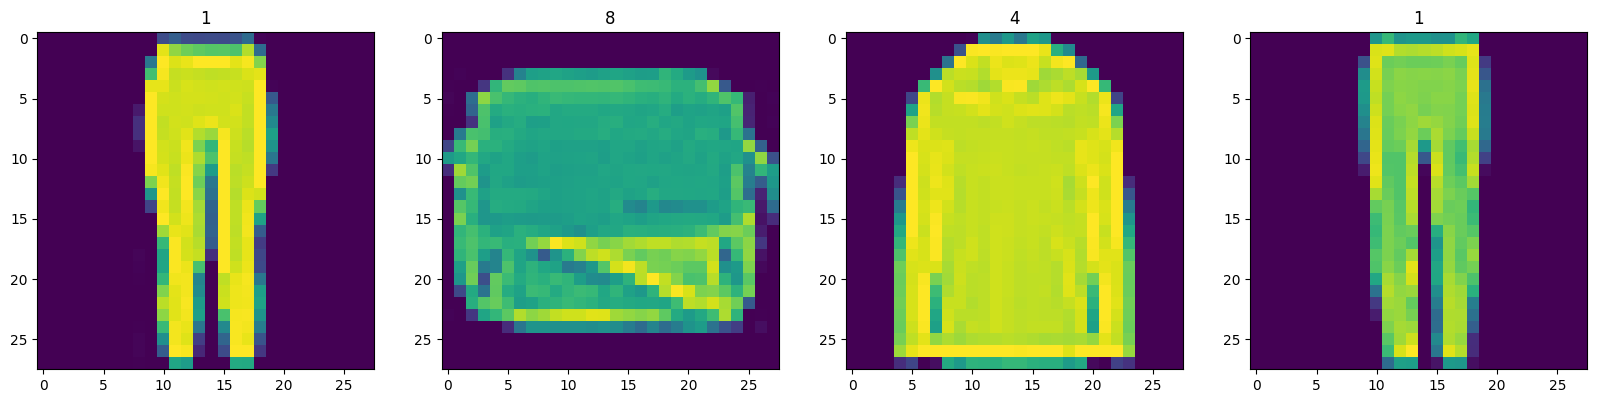

In [ ]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title
    ax[idx].title.set_text(sample['label'])

In [ ]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [ ]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

#3. Build Neural Network

3.1 Import Modelling Components

In [ ]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

3.2 Build Generator

In [ ]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 151ms/step


In [ ]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 143ms/step


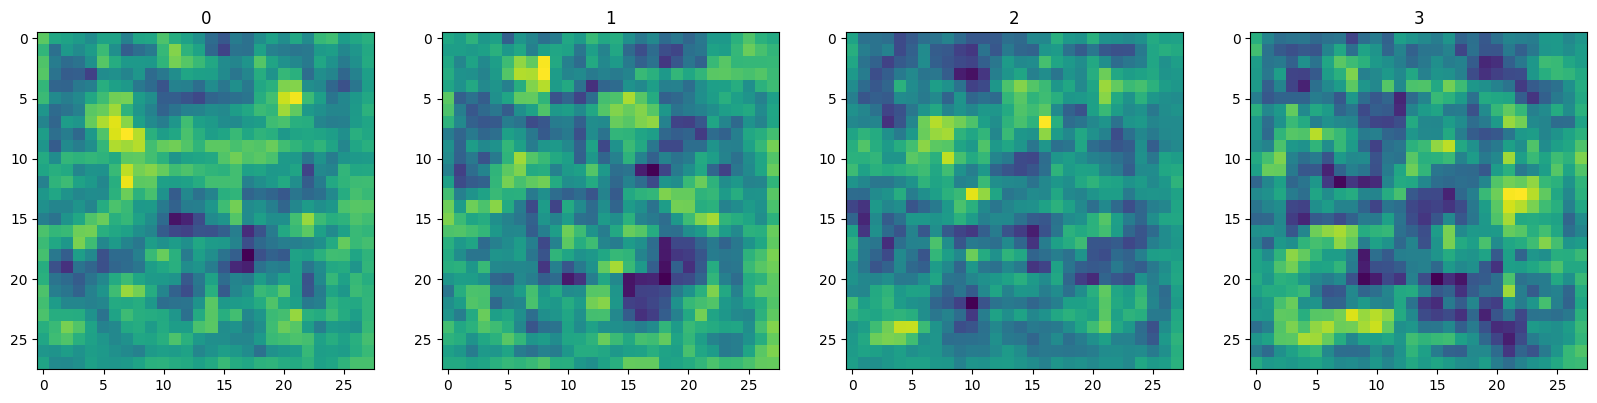

In [ ]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

3.3 Build Discriminator

In [ ]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img = img[0]

In [ ]:
img.shape

(28, 28, 1)

In [ ]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 91ms/step


array([[0.50222105]], dtype=float32)

#4. Construct Training Loop

4.1 Setup Losses and Optimizers

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

4.2 Build Subclassed Model

In [ ]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [ ]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

4.3 Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

4.3 Train

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=10, callbacks=[ModelMonitor()])

4.4 Review Performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

#5. Test Out the Generator



5.1 Generate Images

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

![img1](data:application/octet-stream;base64,UklGRhJDAABXRUJQVlA4IAZDAADw4wCdASpEASwBPm0skkYkIqGhLBNd0IANiWxu40iwJWMdsT38P2U3UvGf4H+0f8T2kLF/fP7f+t/7Z+4vzJ7iuuPJe54/5/+S/LT5m/4/1G/1//P/973BP7F/h/+b+wfti/t97kP75/zfUH/SP8x/5v8/7tf+3/8v+c9zf9Y/0H/V/yf94+QT+j/5j/x+1L/4P//7m/+B/5P/z9w3+ef3v/ueu9+5fwr/3j/m/up/5/e5/+v/R9wD//+17/AP//1g/Wv/K+lvxM/A/lX55+SH31/A/uJ+7vwu5M+zPU4+a/hz9/61P43/uf57x9+Sn9n9zPyI+0f9V81Xux7eMAf57/Y/+L/gPyv9Tb/R/ND3r+yH/b/xnwCf0b+8f9z1p/73jK/X/+r+2fwEfzn++/+v/Ue7X/jf/H/Yenv6v/9v+w+BD9hP2K9r/2T/t9///dR/af//qLeFIi1lpoq6yHwjVi118FcZOEMR/C8rIyquQQ9otkXdN18UI4hDJ/gHWL8kNGXWar9ozb3n6qt1iajZiXxHF6ANy9UBmlbbswYxFaJnZt5vsGKC6Nhz1Q3FpyCH2xBfFsDS8YRE6bYVoSRLnnuOh5+IUcNuFhk+Aq1IT4V0LeKa/c2A7fu451iAYj0AUenzoZGhYaw/T+X2VPE/HJN1vwfS1xGdTgYIwQb/0V0CdgBA/l4GeOwFK8j2vCrQUQwoBiJr6nrU4btRZkzjxBPbOaoLREBEvFFhtTJ/04+7P6oNU6RZ6bQM+MaiVggocL5iP72xmptq0sjUHKkc/3yliomXGwDqW/eE7C8ng808hhghvv81PSSS6aTwhcEFHg2A8fNtLv5PsHQq0r6O4vKMkr+xI55TsPwx07WWBN7dD0U/iS+DKS1fMOtOmiboX8/ldIs8WN8B4sp40rUHngqen50Eh6GFrfw746/WZME6NdjanxnzykD327O3oWuxeP/n8+EGXoXBqU3uLlUCP87HM49IEKNFPE4ayut5bUcZpRYwmkTIGE84W06+sukhOCMWmwf6nwncRfuFJcKvjnmN3vGmKH8jYxmt8WQwR1RBcZ59lsFEvSGsBqYC9SmJJ/wZ6qFIZx5139M3D/9sD9RR7UMs5DVuhdR4HsZlXOj7+84Je0ZpHKwcuK4NRFOcueHUnNSAGJbjI427nbFC6rB8PIJZK4T3MhnF3j4Niuv6ivJcplpMBt7Kp1OuYciRljjLssgaaEBqbfpX1AlFj/7hxQaUb25Xs1er0VBfq3+C5elYpQL6u6esbTX1TGJkaHiIQmwNNw3Gf9KmBzFpcd4xzLVV76nM63QiPCw4Ee7KE0hjQP+Gb52z9Vgbi8Za3mPnExDbe1yxull939cKwALhKHm0eYRPtJSSRZ4wrDmQt40/fHBja2E4oHtyEe2bh8q6cPhO1T8qhf1AvIbSU/fJIEiW3GBkYYI8x0q0G4V4yJ8Ay7CZTY9SCds6/FfmfACwGvg32BQlfhTbPvuQjaSm28o4i46eZVPkVTOMAArk7HOpI9XJ0H9mlxvYiHz3EMY7lI/uUdhNk/cRUSqq3BU1IRS55FpycEndBeqKtTgyfuljpa8d7ThdUSnhitVoLYV6FeG9a167ARULe4QcQuzVgOWopfYfjuFDKpyNgrq/xWiV4o8+xVCP1uU6MYGmbAc4y3Z1MxErZ6MeCaNEbUv9ThX/G6ZSWFzmMpRHk0hJT9yYFXGno2wxhlp3Uted2T/dntbOUJ2Jpx4ixf70PPxiZOvmlII9snOSqDZwk0ur81pHoVjt8lZQtDe2sBo5bu74e9e4yN7xxVwbYcu0+wQTmcLG4KeNK2+at1jUaJyHnQT9SZgUeg60Mkl9TgYJToApH6WM83xZIkG6JmjMnaDg588h1N3OavCbDf+yRYp9GLl6nMUl0Rv8BBXjH44ZcFxGzUO5A3ktICOA7n7e71WiWh1uZ/cpGxFtx/oISbQf4NOAWy4AXlyePCVFRbMkjVlhsAgO5TTGQXBf0VsSnboxwJivBVgviUJe29Sk5YUGOpboIlYbmhojkDCitMj2SMs6iG54ayOSCndIatusFu80heIKjs8MyFjwFwfLMXAbk+ASWuIwAuZQ5wNZU1I/JxjUJZFDpkU7lpsRVSzL+7KYv+ZAv+D3nBfh2TIAJDg5vjwSkWCrlJ8NYZ46yZPjOhrZS96+3WEvj8bIrch5Kf3TlKRJb2nrCg3CvAbfj13ZdTFL4MW8QT7BReJ5cpjxTLM1GnvGKryEbquVmpvLA4OZJNOJTHYYTi5E1hBDktABbUBXqs/Sx6K9tOFoUpDDBDjITBnc8Q7oCaXV6n9uCnHQdq+uSMNOMJ4rFkiSlW7NAa2iowSTyJzeAQQnA2yXZXbUyNuh+NotBHTSBNjtq0BQ3F47LcQqaaK/dhCdWNGbUdbNpfXnWltKw4Dq2dpBzC0miaasAAD+3BuJT1XTlXfXYaOzaRQrDN3IYl8IBoJcq9cTyw5sc9qE05yTk2AoX7IVp0LOFwMhH9MSfRMNCU9KnxHa3ZJZYK0+oYO8T/rkxxqaPu8NCN8VdudWHYGUUDqfcKdwv8W1TuLEy/zvFphRXpsKumvqqfInrImXLOtjZcKgsHT1Fup3tYQhVnuv3/Dto1NWJHBGKiUEtMk7uaSg6UvUg3/TsqrAvxeKD3GFacvaMBqa32REFoEqn7djBCrgghwWl7jE5I2vWsWdZWzgtwm4jjiUht3/gxg4kMPAB4CL9NUU57hF94kGXk+0OgziPDPIiCWFBNPP7TyGwtr6enoIHyeYj8lhbDvuEBYs2dA4XNv/fWlDf4TFj+4ygDKrS1/YRqo/9jATV4KW72tcwz1fImFk3NtU0pDYA7m732xqgEyIfaFHb72cdRpOrjQuXxO6ZZMYmDSguyS17AbwWp2/zofiY/Esp8HQm6NCLJFEPOQ5it2KDrRXKL2PZAIkxXdyP3LG9Yafuyg3D1gtoxpgGcGtXOHkFMBh6c9uYSxnu858f9Kf4BKfKMEqebh7k0si6cXXEqmT5V2hdXemSg6ip/e6x09rHfN+13sBDTYiq0wy/VhVIwaEBd5lOFa6GtpSQMr6iofjGqM+YglN7GK+eb3NnSgBYPfqpTNOjz69MHRoJmTzerNX28GmlY3XQ7zu8NRaJljK9W+Wa52zkRvE/lnETvztPGi2k+8r6DTPuWoI034MKp5MuGvRI+JKSE9oJG8kQjQmZiDcJXjlTeu81fdtUga+Q799EvnoWDuijmVq4h2tiBmkUjmsO/1nHgtIPbMuwclXxWAquTztfzd868VVfpAEKqO2ZnaA8ILD9yKbRDg7widhsck6PVU23UtjhARcGUH1T7V5v00kELWyE5QfA1hBlz+Y4Gjq76AlZCSqadQ8zfKrxLBcWY4DDdDho7KNO/Yo+sjLM+DnXEJMEPwOo7atOa0u5mtrewC5m48Xc6GW0CBOCT1JcIrKaeFFGhXLAkDEBQ5/hgeb8gojH8BECaJusjY7/IPEkC2xj8mMXGqI+iFZOloOFG27nMcsJZLUa0kS6u5sKassQnIDqLxtVB9WgmwZXi9TYQVkval+Ho6RzT7KstEXs6dmrfRXMZaDSZnY0ivzemDQFh1CNZ/drj31HrzN883095EyLJ6V2dg71JhTytG2hkVtG7sOMZSKQ/X8vRX1xHXdEkRN+XMPRYHPWF94jVhezeaqGzq62Sha3vcBy8fGWTbzf8Ue/5CfdLkaekiw8nZUdSsYRayLbiWUAwioLCzOQEA+SkwM6qbx7yt1Ld7Z0XqUGp7dLMPBvTXkaPl+zcCIfbg/ZlVcQUClGEZOoJLtMJqpgsbpytb3qBzaq9RUVT08pL4KzeaAE+cxaOS917qToIOyzICWTMBof6h0E8NureVYWsOkwCisOqn11bZ/sbmZofqGbxZgPgVt1ynt/aMQubrOW0hecBTsovebckTfbgAP8SyhmzLPFRqRBjFr1YnC77DlLT+xgvS3UC6d/NEu1Ilzw31X8gHnpgO6E0tA7K5jvendwpIvc/udtwf71Ssp1rOkIx1W7aPxuvy4pHDGa8Jr8ZASLsLDJAbVi1CwAeZn41ciWR4hFHFgG4/DvNWcTB/IEzAarZrx6aJMNnMY/zGmx7CoJVXHdGdWqSkkNl4uvKyZRYjyeuZyg4qunPvLAiVjlvFan8oqHYA+akXaL1teUm71H1p3qAUBuyaHGe/15lE73NwkFNZeaYs0V2Gi5yfrdc1MrkEQNYpqPMsUoQEt0wrfgAyq3YU6qwmG8Kl9mnnSkYgmNPT1D9ESeYun1+K63/2jBaf3xFqivmO4xPgzC4+dMjgIxGOli5/HvRWlXd+yn/Qeor9DMI57aNLHL2h64VU1WeVINlRnBjQUIBiVjb4kxOjt/GxN6FfEU6rn5UJschy/nQcpzybU12mW0wfBk8zBsx7vpj5M/fWDI5GjU+mFEkD4WS3oDqMSi+t8zriyzWytNb2OlhfyiPJL5u7jry9ZuGxEtu8HQjnUGEIeF6eB8mOb79Spl4ZRf8C9HUwMa93jdKP2BuDVYCjTZhdomwgA24z6POH/AuWlYpap46CptdHrXP08YBMM244tdLT8nA2OYh8KkqkbUooYvNO34Lbw7v0R9UeiR+8m+flp48todfvQFtxDCjTILzevtKBjoJAr+YeJG3IA5Ed05wlVd9337g7WnZrNfo2HFTBOpKPdMXLwPpfha40PS5pegAKpP0mpHzOdSd6AvR9If+8W3s7gP0lgVJIkXlDVvGRgWVvYi6y0lCV3XJaqsa8UeA51uoX0MG9ulg83GOOO6pWfBHjG0KL34FtJexhh9r+aWU/f3ULUD9HTAJW5c/Tvwuv+FQUz8+PeDvRFqHZL7wBSZgdZ+SKDOpWkta8SBjYh+u8nkjwkWnw4LPBNkDdQlIS0OSIz2nUBTod9IP2PXdGyfwqV2N5nowe1/nWV7RxhqBcnEbvxP0XrDWnTWoOvFU2rLHEyjeuPisyiGP7exU+MSIXgizCbjMG6qf/DGDOsgsgwPwv7rCCzm96yxOl/E9yDNmYWSlE3b+7E5m7ntgx5zf6WMvIHU1j44Yxs4+kU33ShRz3Ot1ng/miVDOachGLLKUhWgx3CZ9RriLO4QLZu8e3r+5qy8cRTccOzOE1R1iQvMcu09qYFryMdP+NiLooUEYYJzfP5LBCdGQerT5DHEySgD8daV0iWSJktim5bdENx1v3VJTfcohf4erWKizyOOW1VpCzMslxedYx3BGMNd/I5iPR2jpBIhrWDBD76BYiZCmctgsZHY2hTPdEhyp5n/UWp0uWWJhWiWXl+UYkZS6r58paITyVesUDev8NNJ/3uAICwm2fKXLaihlLzqVumWcrVXxvON9WS2x4ImDJ/lSz60MJWWJxN4JZvTzgxTyE0ATrTO4QPmsE4Bzi42dI6XUkqN+D/8mssUhbMPXFSVxdu5Fw9lYq7HkU20ERU7ttYOKecvn7HIhIZ2kY3uhJMbVsnLpUdhHz7vbLqLpoqpS8j3YTErF13LHjYt8/y1T3JBOU42CZbGWdL0lJCd/hhG7EUMbgoeXuApWMRfaiy5wPlaCDCEhi3WZsp03V1UggnzsdKkfVSe8r3EDOOgUX2OH0MuMXZd46XdWdZaVwPyTFWZ8Ld4itfdbZNiWFG1xzeBZNNfBZfmiG/e/3k4VWEB6kD+jJADtQjeVZ7wQOpbj9Gd5AeiJPWS+w0Kjhb0gj9MjPXWuxaur7ZZBE4TP0vJSFrdNlGVElb8fr+SBtQ6KIsHSc8VXj3lY825v54yVFI+RX0QdQr8zjJAyBJ8/zXk/xoiBD6Vx5VaDsLjctZtSg9EjZt71sXAN3+Nfxgl529gdjJcwew6BGWqdA94AxzIbzI0Yknkp71sH467GHJlnLXBss3BmgKfTQzAJbEPkjEZlxAoQmF+BckOyt1+HVBsw90DYCVcCOS2ZZu+IcgDndXoGCfI8oT0cIasrC7nPsjmpWQELemK48pboIjJFVO1znaBAAUwxfyBkQ8CQ7ACPxXCaFDDzSnFx/XIjCEJAmZRdqcYlbRp6ftm8K13UknP9fy3bjP0cg/ZMdm/yTumh52x0/VlvdwCkG27XzPcvflJY9ZtCebFCc5ydnVZLvbQp8gjoqEgvK02ceS3e5+EiKKkgjeDouXMENUYxOIe9nq4JAIZhqxbn/p9/7woEKQVeKF6u0hd2/JvZeCtfWfG/7ps5HD37+13lf3v5/7fsqx17p7YKSDRIaW5/E/8nXq99b2oArBULYzoCzMhiywm8q/e1lJxtLtkC1pyq5JsEHmIOHDTZ7NqNpLIVnDrsQlkZSoqMYnyWdZs0VzeHpdpkoD6cBsbgltvGPmizZGMuNJj9sh2gj2EXbJcFNgNW3c1koHzOknndaMVgaAfUg6N2z1kZlEBH7drK2f+xLgzat/4pxIRNryQhISEy7Ej7XV/ayuckixkr+4qvBS2NdhBsM9uZ2QmF7WprAVsOoXR34bG2Yiwkq/t6MYsUE9fNES2V55ft+gVl0JeIedNuhSG09aigK5x5xjTFC/5ZKvE9BF11QynckQVbAtAFwU34HQwCmPidF1YlyGEb0BaY5wQ6A7PkKXGLTRTaF/93HnvoWWwhv/YfU5jUMBrY/z2Rn5QAEBS21HSqN/zr9PB8LWMcS0alSNorL7ZJH3SRoVB1pOFudLJuC7F7UuncoZM1njsH0Kc7lSih64V9tDHLwbSupJR57CW3yBEZ9QNixmdOzxwwPzuuxuxbmDIxKBde8n5iGKPK4Na4RVUdJDsSDRzZWkPSwsFtJz0X+j96VGsp4HkWwbFVoKe5iwnFxK5J6xXfKmwGBImTb7euR+Rh1wuNobJfrAHKgZvfNR99BZEGHZTUvgmqNO3+ZIyYMVjHubvVXiBPq2JFsQnZu97ZNTFh+6bxfnYYItWDrfKdvxGgbYoxwJtF3k3UCIpwxIdnSdkQblm4bNgqhlSxCYkq2sgNLLF1UQ9ImgoBrglmhuuyUP4xff3bQJwKdIslhizsABkBPYw9cQYhIcS7q/F14QPY59TKAE71lwTqlw8lHCNy0PQj1LbJkCfPEfVaZLTlnt1TJevcNkYMI0twApTJDwppFh3UsMfCTB9bPA0F2GXsbEFIqRdSICvVKczUQPBpeVtv3BoS7H5EFZLqmhsD6CvN1VIL2kuy9FTrz3YJiC0ZH8yzg93ocFBtZYuSmnagbZlIkIB2UX2mJASfjC0VbZfbRz2xdH8obrIX1jjtX5YMJgtHX8Td6AWKsvLgQg70fnK2p438qUAVrixscXwEOaLhOEVovl69PQp+VLkBKhPRGSgnVYAi0qHPO+OsyaS08H3u+OeSEE4obVZ2ybRV1/Q9hepJOAf0j0gFDSzGlP6PO1euN7q6A9PEFaoEqQo4jNgHZKvhDcXnxt9U2Dhnbyc0fi0OacyHi+U97biF8EZeOv00blIDWt2E4zyVfIN4Dn6bkOuNBnukWdc9lf542eO1tlscaS20bXEs20ArWY8UiUPA1IgB4Cgsa4isGcxYAPOxglTou/XcPA8Dr/6h01i9Wc1EtMer0gKoVC2+rWSOWe7bWVwlRTbAoGrodyQnQUNPO4h7J8am6HipGBJaXBtrSY4gF5IpxfoUcIVnwob56BOx5oH2rVekduak41NCoOOuGcTx5Q2JroLeMKmPW3VYVXLjROWW8oRnSI0yZX1CX0NjkjpV3ZL8DyM9mzz4TY9qtFxxhwh+4985gvAG88OloM8dZIXC9FtKACD2j5yA7JpBqpAP7nT+JFR6vUbDviLBgIXrfaKS9FZ6KrZTNQgwosW2IBVW+F/rJQKmABAqC+5fiwqLAiTWF32VUlORnM5OnrJgGkwR9Xm66CbxAYL7b8+XEc4Oma8X5VPptWXGJd9NgfSFyGDANHmikEaRLuC/68M4ckrs35KUZ2tYKGQeBx9Dvd7fw12fNc6UZkiIYAJ4k3Z0A/9B6b6Ys+ZUg/VxCPzDCdeVANf9pPQuv89kgc1LfgGwFJv4WVe5fjzcmPe5vJsZVEKK72CWPUutmf0W/uauHOuX0YotF/6OxtT1JDxRPHbDzByzma6KlHp1kCxE97E28Q3LTAadcbdluJzgYAUgWHGSnH2+OtyH3NlEL/XI9aFSmDhpRTiPotY5/TmjjZgUdxx32LbD/DaXjt8rLLyQZD1W3mM9cYuiOeLaZgM9WC4fccsKMFrJfata/gu7lbsDn+a8ufigNMwxr93LdvgHoVcERfSuvouAmIfsxcPH/y7t5ywcK+khZ1Dah5yiZQYun8InLUM6QATpQDunATCs5kEz4gHVaYY7BpIGq6fDC3qRqGdTaLGA4deZa3Km6ucKG/qRa5Hu2ZCdLaA+A1q2ZjDMaDzvt7nIP6Eu4gAbJdnFgqtDnCFAxCbbCcFx6jPh9IfnnKKMRIyPp0bqHXqAsV3tfu/CyKZZsRacavZ29v2ioHemERnCdZp38mhJsWsguFdJEH+ZovRHEBT9UklQEnEdjPBBa+R2fCptcSQWXExKHK1+4M3pKEHTi/aHIdGD8P35wmXWSaVnIFGrb9ccg/Hk1EZzBk/gJZQdoaS5IJQBDx81rCeAnq2Q2CFwTz48HAtIH4cWBYOqUrZf6idDioc6SBhBWibuUokRG/Izv6s4Y8y1MpBjbkvDEOLuGd+4XqiFo0cXa98kD7GbiJq69OgyRfekE8LyjCjRZMSB2PJJCrhTHW1ru4J+DiBe/1IZfGToT+hWbPltaMaLsRa0Xi30hOmwTHVeb3JRAopkR4qTF5FQu45tVwOOF4FS5uIvk29DMhxT8/DW4TT7A9R3+LiaQ8V7AD5aNzbqKwq9VRURneQ0PQx7OLFt+kKKUxGbqKM0ALmDq3o3b7f7kfxoRcPfR5hJ971Xa3RrECE/8MJOfvQgrPR26qQqeFqbEqdjnK4KbYXqZborzy2fkooGRwtsk7WE2uw+wNu3K1a4eq3BQOdCYacGUo9HCU+UX5XvWITF28H3Xn9zc6yNn0g3b79U4/WdViGVoV8XQ0oucfVFMfzzIzrVW6duYjgGPvsDwpobeDNOopW+xgY2z+BJ/5dM3GWwpUzJfF1hsZPu5nJr1qoMTXA2Y1yTG2DNDy47/k9YlrHS2MbZb/g49HXSoHxu7LUQbZc1AQvpHuuQRP33Z3wU4qmrlvZsDiUiyOtpoFpi2U/LI48Bt1krJ0BEd4x7dDesnCTVqrHa8TZPV+1M4Ck7v6AkDKvdrKK1qZhiufHNBdwTmxWd4KH7F7lD/AEaAbfBjhkLoOurKn9Cnw9Xj1xyuuywlVUvJXs/QjC49oeZG0fUGBIOi3LzRLKz9JANQ8V30R5KTH2e9Wk0mbhc+ei3plVKRscLH6E7ht9ZsmGrtzP0d3qMyj7F2K1O1WLMjxSRLDCIX20P5IhUfM9rI8nVw5CDwAx65pF/oGDk769ifmLhPbIzDOZQLModPAiVFu83cdtDQamfAihGZE556gIcdSxAQfWpYfxVFQOIVgO9FIEPF1Mg38V2k+7YZ3coNDbrkGbuuwrvnikvWfPeQPUT9k6CK7kfp/OijR7/y6tkzZA0bbBU9MKZN0bN3VuzZ3DAOz3GeAcDgymZ0GzxIHzBYAj0D8Dor1lz38ptKXn53q7VFcqbMLnK2fl+U+qkBcB4OVI5NQ4YsyTgYU8A4q2SJpTkU6cvhHIWmRC3J524Vhm7LD4Qu13NLs5BiKfRLe1tpCa5l3+gf5jY2o3U+w5gZwvXnDQCBaSOvmJSg5rmEAD5k9wo0VQ/bzhdoXKlbJSFbRbeEplHGQhL2OOYAoP99I9lVI31CYViCwACjJRNd1lwpwhgldTzF8dBJZRmMqxx449RvUr6xJoq9J24Ww1SLeIW+svJ/+3+BsulyF1hM+JHKASdSJFNKkYiQKHphcbK637NtbLAORV2cgV8W/wCjKAVVFC3g7fD7Dj3jRghnclA0AWRfHcG6J94yqlIHksEU41x8xk7+FC7WFiJyfMRHKiHutsZ1KAQvVJMexRf4rX4YA8m1tgRpI/ecrAGYpUBAZ0PLpHwHAP5VjfjhUlyWKnn5y1+H03Cf3tr40nZB4zJHtzDTRlUledDU2hxPYtlvV/ZM5u0qvil37wuF6vCf4qvXY16Az1XcWBHu5aNd5dHcMxDPyrKGxIxvQNvXCY+EGRROVScnrtA4UImy/GbVFkbBfte4nZTc5VYyse3Mk/ApVDb8QaITXdBt6/Y68GPVtMbsjoKoYpMdNfFaIvohke11nrEiTyJF3z3Vk4HunCkbdE4AWQfOnSoBBmG7Ad9QarhJa3PeoD6xN7zGm3ras7n3tvr+7RTaCBsrW3O0rgzxYDFvoh8OGGj+ms/ZRxv8+vvkGeQ4ZS54cwG4q8BFmkoaoTnQb+XpBDBAXGXOoZX4ySKxMmPMMSSt4nVZbfndIEekDw8t0nrAMIqHyzEGy8ADO3CzqEpDMUtIG0FJLy6LHLqdigYI4YimzdYVUaCaeHuPWA3L68IdrUVcG/KTuESK3reWimljEAkj1NVU7xEMiOxKAKam+jth+d7b5Nn6OEEuvUO8KAH39gYvMWNBr5oFPcEY0aOecv7lKgZGnNGAmuODO/HURhKtWuZy8SRifvB4ZEjkvXMVldAqd9v4lL9pL1rZfBN2QTsuUoXXCI1IAvLdElr6mZN4aSwT63aZPqedwBRTu5aF7gnU+Ubm47sh0m5izkoG/M+E2UbiE1PgQZdRH3YxH6BEUq+UjKu7qKNL7ZKu3HkrjH0PEtQzFq3GwRgGmlMSItMIsmutd0hO8JxiEYq/C/ZxxAyn6KXzvhzS6m6sWVqyVg2K2VwueOlPnCnSb2kYS+kEvk0lDEySWoqCbASK+/RmofyET2Bnb0xNJwBAfbBKx5QFmr8vYIIOcXaaxagwFPH9bcC73cMYVp9Ard9pCzkIQN/Gxaql9iQZCWvAwEi99rfIBaDIaa8xlNIGPB9tkR9z9KsgJbYBRTLzFVC8H3mAZ1IrOsXQ+oJGRxOiqKIkmMiOpXHl5pYgWsBqTidZcucQNV3aJ83VAttoOEmFOfoW3nkqHMkhy9x0Ub1aOIuS9bJo71lmj6AGncjkuzSaPPYlkoQz9gIR+u0FRy/jGIvUBrIhZZy+RzDPjvsP1lm5xa50syzHnOJIYhsvhCDp4j5onxlWCZbLMCejZz9mFuXqga74LyKlcXlRawvn3BRMxYdeLVEbOEChcaYt2EwZ58Rv83wvKATgKa7nEuD1u0Xk49aFyFuVkMOQ3V4P9Whikw24KY6TNKAob+oE82qFII/chgLK4+FIUibyiMiFAboG6Yz2Jsf7w2G0/Yf618zk22+pOi0yLrrMAK0EG3Jy3Y50syCF/wnW9P2G9W6QKdHdH7K9OUXzMeCC/2zD15R6+DGmHb9Nbl48gT90EExiPlyS1oa17yY0hxcnAV82tCsmWor5YGxsWawwwUwCqhDxjGARgBPt5BWdtPlDiIeV1NfeiS3N2ZrJMNoUZLLHaEw62MYicBEZ4wiby4Z3Qqdo8EXp/eNqIqalGibZE7djXfABh3VhPuv/nw9JyDt4zKL1lcAXMHuI2VFcj/lu2bjGlPFXR60udNCuDvgbklaPK9HXODiyEBZNgvq4UQDdhDotBi5ptah0sQ/uMDb++GXH+6NS4Cf50w8GJAkUaliTuLQczEsTyTAI8OUxtdKcS+CamN1yTJebLV/9gFBpvWvqVLEb7fqBQvkyIGzJ4btWaUs7N3EfUK9fY5f3P5ZcntBF4+Qvoo4KlFjYitMHi+BngrEkARDXyqrXEpmlygTmL4vUhDcpa6GFOu2FSKe3JEzOTuJH3WyVPKk3dhjZwdqhAG14Gf7+CjNkXun64m5PsLxKhBC1SabNDsIfpVDCWvCJueGWA/nOtK9cQpDmsnX/Ucr540qc8XLgudqMS/hJ1BAFYCT8FfyOaXP7P0gzcBDG9B+MRNG+ImJTswIPoyDaS26kUwFgaKL13tusuRkX+5gDwawoXZUzW6PJZVYswLV5TGes4Y2NfgPzlqNlqRhr9cNkhrj11kS3lC4u/9XbooBMW54biJfj0lJFMxHjRRw74rnR74BYOYwAUPznMqKqpmRIAtXZRW27uN8UWeIIk3EkVS7VJcRvVgVPZlIyZN/vStqpZbwACcIMBWum8SyyVeKx2DN7iRJXYCGdKNtY6aqpPhADZhdio7FmQEQE/0LEFQJqsfGcIypM+hWSVDq3SurLfUuj3yn1RnBlLX7ZKa8fWLY4+nNDSH9plJ+9tTSE0H8tYL78PsLYLY28CXCRjTX4HgQBAgwyQsdiO8ReAOT4rIfZfzcwBi/etUdLH+YS/wdddUtPkNK3/IdQv1R6szsD9LdmgT89Q6cTNO7ECsQDykCqq/tz0y2fzXJxYjCbU+PM0vQhYKXbBg/B7rsZqu6QTDtT71JiD1P4ppJM8Qiyp3PmqDOIa7pfLil9emjM0kJOokxJK6XDVQb5vrG8jxLsCfGVqhqb7L5OYBzlB4TcnA0k1WVmxITZL9kjERdkJjtnEg0ZhclKFSKM/RwP9xGH5Aqpaf/dXlpDk7L5h+9hh4zky/fSqooo/QLrGqbqyzoglxiU/hwU0FKiWf0/n1+BdYZsG6puE/WnsjV1G7zF8J2EEWUz+flPxptxCFLJ16i5JhlYIASu7q02mcWHssmMq3GAARsA4+cZF1ATtKLHYOk0s30gLRbDXmmhyIQqDZboCDFvw7RsfMmp6Kbbb09v4HOn0DDOdmlMEuPxmQE4F6JNUXcy4yLmHxTdp+lwrKk3axXFPPcWe0hCGB6Do5b7nT/1UczgQvt5RHbZFavN7Hy4PuEfg0PnkEmewGNmpfxmeNWjfxssfY1PlkEk6/Vp4yEbYj81Zbr9XZuijEJwnm8a5QAK+Aj/g3MW/4AkneXFnC09J0335BnEulEjDAVUq7nGewg38xkSY0NYUmBLEXaCT/LcbupckQrhl2ZCVe8f4UnyTHmUg4oqwPh3ci4m93LoFtJBsUiFWWdJ9Tok7SNQTQXXVQZJCpWTSgddcc5zewBnjHEFvxLFP9QULI33+mVWaWWz9tlMKvKOL8woDuQEqcpXQh/hJBKenZRpY+oheZD1vCxjsCZqOBDltN8ZgRy9MTsGT8sHlhDaGLd4o1/TgvcPCQ+DGNRMygqNceNfUf1j5cKlKG3RahfHJgKmUuoKQWfp5jQz7zeZwdA+8jQEsaC92QozZex8/apyRSJ8t6xALIiEk+WxyfnWTf4RVvuYfaI2AOA4hnQ1YyQTLiTzPKt79cLPzw9aPvX4E+HZUrF+yJeSX+2WjgqYiuJmz/Q12l1EVMepgzQluEWCHueN1PpHi95jzUarBRJl7WkjKeUve8pDMP8NYQ809KdqVCVbG3Sq0nokgPeKkBKUF5kWQj1+sirwkAt9LuWaQ6fArj0201BZtCpqx1ufWboEpYM78wuw7W+SzdsECsNd00HBsK0emo3qhnG81XuvmS2gIxwGKKSOiWy/2wkESx3VJ4J8AgUJTUKMMolrbvD3/nl2ofeogs4F5V61AWcr6WGpylv73iBke3a5dpI4yHUM31HPGdSnX48aa31JX4Hxa8WlcHLfXYhufi00g9RN0a3bjjOfcv7g/Gpg5X6qIHRcfkkL5e9faiL4jTQU+cOunS4SdcAGiFRBIK/SBX163J8oMPFJcCmfn8K4B3m9oosCWJZvd7wSz60SvO5w1qBJw+mCd0YrcQbUoDDlHkKU8E+sDREgzKx9R8YPCkWxV1Wjchg5Qg6Fgjtj1dbJ0ObMfiy8d9qlQonUP1ki7/dSydS5CBpx0Yi38ti2SsoxlKP1PPMkgQsX+HK0/H/jVjTBkH0TV+v3sWGQzUzVnHqWNFw6R23cX3B+A5RfIne6DDUDNpVkNlBImDSYC5UydrdCpP8dQJ1skWB2o8rjVvoig6kNrt6hGeaGJgEwruh6j3sepuB6FJHSsuwGruAJ8H+waJCmAlHTggrV7bhUgju6NpzK8z7bT68jpsnosY616bBzz6GEG53uv2sLZJpznqkUJSasjm4De3JIJicq7HWpTZS5YhIt6Il33mhat2ixX6wQdfi8uKX1Xc66Mw1A7aHacYExrAn4Pywf5izT6hnrkCFY2fR0IqZbLgZHy/MlL/DWe3HyRORWCkGGx/xbRGM+afBfhQRbhko9UYNPv+EO2B+1e8hWgJ6SMoJjZjB4BcUWbe9OnxLUopGN50VNL0kPJx00wwj5xME/UpVjeFyrRR79BZOTrfgyyOX3/qMP76BRVzusZPTgR7EktGD2fMYbm9oMn2td5E/sS9dJyHtEyX13y4Gu/tl5J9zpKHSKwDWRcFSRcV1q0gGgtkj/0wKd/sSKZ4SEYwopKN0Dv3NGhyCtGSHnEF1CRH2uSeJIbXCdv+xak8yx1JjCTXdHV7BQMyycbRqwy21G5WB3KvTcDvAAn7btxrwG+Mf5j3CBJCFDYnOZaVxNrNagneHokWhAu3JKiHj6jPkJP4bthfRHQo49FXabQAoBztIBQ2FwhBLFIV5at6CipSPPgRDLyCQcIV1FarTJpH0LCmdiWVTmzmx4lJDRqeMWD5wKRGQotZ+CBj7nMjrI6HxuqKz+gTxjc6a5GKI374WzWpLSFiSLHL5VaTaumzvVHHYn3tid3nVn/yuaPeml0+crI0PObW3zak8KQkoRVAwLNlfstiIyUtu1PNfyxWkSAsXHLR86MV40ZJr7kHLhOhQp+kiZu7b5mDxHl3SYk5IgBn7IAq6fru8d2y4SRlQ48Yr0s9RQd5gvjiJU/G+Bs+fVT9o0RElucuHWxHc7MTxtbHMqsRHfv6+PKbb7FzcNLAdHzEokM/EyHOwwI4giaxFLURXppiMnCoPaze84ffU4NY1Ot6E92UuTNJNfFxCoFIzFvZ8cNn8I867yrSaiWeBBYfCy3Mfvm4tqHmIbvOGanTrAAd9q9PMXqMg48qCJxSmNSAx6l79Fl4lzJW2jm3DYimZIXeeSDV0f/twvN3lv7eagWMctIATcGG7Q34zaS7e8B1R6eGCE8umKmM20pjIhaSZBy30jwC+dr4U8W6CDh6D5d59H5CZuosUn5oPQVRnIP8ifwWWMO3JU2ijAP/3EF2KXPRxNWiZ+7238fnzJLLgF7PKnXOtBHIj547sYHIa0WD5Ta6SzlQwG+LDPfOT6xSbTL2gVDogqB12Xkl4KNn3ylOZNjVFtrZFjg57HU57pJ09kARODphlASwkNRpMdPeDWb5E6wJsePXG5O50krDwcC5sGA9hs7QMn3i985dlaUbtp/Ry109bAKJxsM3DwZMjNeFOnhX1OkpE2AnJF3pfoEdDXa6+FDaX3yRmjnGrZ3rM5FYukINuAMRChUbyQY+S6/xKXXlNVkM+nKw0uAKvIm06qosCObeCYeCH4fX1l/kDkNR5f81Z/wcl8LrK5hbw/mz1KHglNcJD7QgsvmBg4jA8Zd0jlqHPznWRxs4EYNWSEkuS2Q3MODFhO77P68vpIaA1MSskCd2/EwHeor6V5xYVMNTvLR2Q2a2OowqvFPSjiLh0UE1O0UOzzK+soOipCSSVMFWGYiUYd70vXFZmNAX/oQ6PyCGc+tUGD8turjW1JYJurTFLPyifBHHjyzk+3EpNT2muD7cBJVZZ4u06wFwDhXdRtDE1Hm7USSXTDgH3+oqjw1+g/knC3weYXrF8bICJyJJ65rT+KWuwcUmAL8pwm5CLZWAXeRMDoDtgMzZE8rUDkKfkmlEe6hWr2RrAvobJ1MLBZiShyGmZftuKgM7iQPs0EhYAgQ/C1If4sNS5/OsBRwcuaGR9pQ8TQgGSaoi5drhZ3A3UK4Zg8LapVnNcINzYmU2Rol8+OAwPP+cb8gRvvr3kYt0ByqobETjtXQQqHuCLweaf9OLptBvISZzQndhRWsTMAaC8GodTUVsIjRgcAPubYCK4NjwksBKUxDnR1yXBa14ML+3EsiFdn+mSqTNCbIBwmDD2SDq+mb/v9rZ0kmrpvaZUn7KJDByMZqcqGDESgVXr+LxLoMa++Sxs8BA9hLoKEsVScvXA+e/cAnnInEZip3VUXL90Ly6XU3vPfPXgsTgy4sPbT7NoLXlkRuB52Bx533GU7ayGkzqdxmSPmsBvRUQPDDb5ebljPL/mtUZP5CMI+RlIgAWJoxQDO8F1TCM0Sf7G1uqugSyHHRYFQnWDXnpPi9CHxrtFjHJn4SsAworj8+f61t97JwSbjBSbFJNy+32/kuaFPeawVTP7+b7qW98WzA4DhD67I6txmrE8FgFX0kB9BNKm66GxuKn2lnc1NfTIhX+yHCax9epgsPQrJ/xSi811mc4WkxNoNH3r4t6vFvRF1Vil+Lxcgw4N9K21cQl0t4SkA2LTLr59EYiNFZE5y6b31OWIXqBGgi3AuXDJM/7dzHaN55tOzFD09ZGB92/Z9aM6v5lIarxfyMJg9O0YFCPkcZ5yRgWJUGWGXjWz4HC9k5M8cIerPWG2EVt4nG2TZ3QDd+RufZeCxsHn8oheCxbYV9spQs0WszsylhIkH0cgkpEvXSRQrjEh2Sos+l/+hOppLR4XtCM4kgy5XfRz7Nu0VBTnswrSXUaBYD8VcEb0KbwpP0frenkMi9wf9t72RZ1zfE8cSm5LpCyz2YyK/Xtx4XmXAZLh0bEmoUlYsfxQdse5OSqUTtsKR5oYiMVE3It+XH3JjIbH7/3XlDo8alVW+zMvybmEQO73BBWQIhGuwyt9oobgkU3P9d+KP14MpYCz5sZ8/J2OMP2kGLOhBGz2Xm074+ZhElwT9KOW3rglC5+I2FAzTUF2u0dPDFUfSPT7qC8KMz6iGHHB/UT6SkN2wpK5IJ3y+qOaX8fXigSbvs9LoPHJbZBY/zbB+G+tH2vgd0swkS1BGxS2ufwO7bmWdJqlVN0MKvBFP4Vw6SjwMQKGKpLcWKRBEsw+1COojfO3qk4obZ+5/9M5XLfkJ060pVO28cMPevPzR85TY2nnBChc1aiopiZNUFDUxuGjHl8iNyB6vKAWEPB1Emne9cOAguUT8JrYW6INgTBZ3lwaEyqrFSlUEK8EEQVgliWIpfA2FqOsqNpJFwjivrOnRXMtttECiPbQXfG8zsvFBpztHZpbyf4U1rjZRSmHO6kw0R23/Cg0VNPRpiZYXIzuqUk18rIPgf37G0By563Q9MRzihC7OBJfuteFS344/i+5bSPcL3FcJRyEE4/PFgawLxRr6Db3IyfW60PsjvDpPJwThZ0KelKLzIvHVeDkYbL2tHFTnZ4CJN40nS3L/EU2Z1rSwn7SIAY+CuBNVs9ogNVnm/btv7BsqI5vT2MYC2WhehraHHod8Yxxqkhv08LUWjIFzHnq7eA9gYjVnzX+bpOnANPfgQCH41urTIMTayFGG+IY/qdJdE1xNYh94BmRX1bGGdqJxIspu+V7oDdNcVR7A9wYkoZCfYfhzEihTgLiGWKSk1DLkkFLLXC5NL9ggkGIZQPXGEcKJ3WvAjh9mpx+Jwc0JMK+YjFZMgbAxo/HQFFX+62gyUFXzztcAyoiWe+AcnFBvBZmb67noZTpPDYib85xuAOtc1IiIruNU6b+8uV5wVQEMtroUdnrq25Li/S2p7HGZ1D91wbPhpXCpNTf+EMoXzVtEjgHNXwT2CGhxvuaE25YIPmkEYCO4x3MnySSqkWowgwSPDYQoDd2HAtT0tFiljcKNiBggMKUd2HmOIxgbpINUfr0GnVikfUbEpmUbt0aE/ut2GmQnKvbv6Da68fsYAoz0NUWMM0n6bgPEZQ4xjjgbqxmf3c6vk0CHPLR92azorjs8O0cok/ahZvnI9kUkACHKJwPZoiuPjxMzhildwx0qyEJ1GDKMvoouD7eS+Tb4crk7OWWJZZMcMqSS+8MqsA9LVFPB1u3gKJ/Q8u+bdIRmDjR+YPVVb2eFpAf0Ncj/sxAv4ITW98l1z9F2HGbkOqlQBnOmnmsuYKdBQQeTeuHinnGuENp15lC1E7afWD50IDSo3RiFTIH86IdGSKVP6CeHl4XJH21/HRmin4C7UmaESXxAxBtceByXeuU/v8igHh7HUckF6YonIOvibBqmg7aBcF3/v8Goo9pAjnR8VPwMufjF2HqEnziFcDWqV+gGcoyWrEdBuB2/c5EiMVBqYGA2ehOicd5DqJZFDgzCRfDG4Oa88cJVIF+pVGfeJnNpWbHd+3v90zE/UMXmUm9NIBiSGfaT31XOm+jPIs6ZeYba0dmBlyMilF9b11GpM6r0NRnz/w5kzbIUq0m6id+w2Jf8FOoDwVpP67KMO1vMWIRxhBkGL1ncr5pc6QRt28e1I/Eg55yAxketUFTSAdzBWBsNxl64N0IY26L6lnMoZkeF8TS2mO5yDVM+WI4CQOTiysJ1UG4QDsF9ifF0MCq7ARKXXxe21CgSWnS1Yb5duylSJHj5R92Onc+aQcp0VtxN0noPtySFKAJzxyur9PeLGIeNX4CuwR517DvV6iFa7k0VaJB+Btr2yEEyUfRhKb5oWTWIndEx3fyljSKbhWjbmwT+so5PwzFqZBPRB9T2kvbc+4W9jZwam3pjQFNz5QlT+RO4Pvm0GDmAQ2wsAjgvB2ZkjFnxGCVbmouYtEB7oF9cOh2FDv9cMOkWDh9XFeMWiSK+ef8qwndc68R8uHK5cSmQxpuPmu6n0ZbeKBruYirnsGjUu5O/dBsC0TA8njKeKj5jubZwNLOGB3Dm6Qjh0Ru8tONUfhSMwf3h4xjMKT+Oq+N8mhAJO0V10KTY0u/BDUWOO4Z1a8XGBTwKww4gaVvYkt+YTfpjyVbc35VZK5j/QMnISaHAjE7aU/raH4/9ea8RdtflTwXt6S2g6q7g6xjEdPemJkKIOZLCtdMQL79nVyqOHiLIpYmDvoYv3+v9iSNtWDYucO5Z9ZVtJc4JdeXN8Wfv62xaMabnNAPrFd1N6r+KU9F4Pmxn4oHDiXb8Qzvdn6zes74v1LiMgmJub1jGPnKo44g3A/xVgqLUjywZYjhSFfA6qjjVxSQo9z5LUu6I+A9XqUROPHK91qnO+7ncQ/hjUffAKaLfbdDfwhcw+uOpWkq/zsSy5E0LXHNlvDpIhrdj5zMjh0Cl/eYWNXcu2ynlFACoDz0v8IGJsPDPKfwQzgxekhtk/2WCTGrxqEKfDqo9yfpGNJYahOzHOZ00XgnFqTdOzf2Avt4Vgb0HL+52UvhT9XnaUabFDmqbDng234RKsf/bNg4p0WXi8AEzX056rULBbhYfJjUJf2O1o8hFlP43V3+B82BEAr1DxIsA8jMZbtsWKVd4JNLACOPxsKOZBdGG4N/ZmYenlaQtaJqwnidgVeD+4DjaPaNYmK2YQuGhe7g4cp3rbiuECkctm+FXp/g77j6XDTZSKB+XG1lEIMT75u0ur2ZyvSEPkhPY3Z2ycvQY7KdQ+2oY6ez4DfhGi/dHhSMLpUwA7HgqRTrQM8cY97f4VgbZZgp5S1+f67S6Xme/xI+JTfAZ5ki3ycI4vJTBwzEiiKLe/ESWW+3G0rLew/xZyJaO4UYiqSQY6Xrbb1/yGI4KaOFTF3PNccqQVmPgPPQkcMe6FWXoomD0fSSLqjnHo5/Me17z/v8eYcdiYBxfJ0zqzU+8ry2GhCI20hCd7KcaZFNmDd7QhZEDYkr+ixgBYlFsrINBeu0VpM9XYCNiwUSNMOCzp+MtSZXjs2t+rB/0mfBvN/LQ3IM8FQn3axfSAtSaMmTpzFge7F6D0quHdKt1UusXCzNyoU1kkrm0W2/BWFNfk3dZmOuaDwFB2hEUHg7leA3THs4VM9g0Sz0LNLxZb0Xzqc3wI4dz6bZI92p6gKTr4BZjLwBTE84UIVUcGv3eJJnV8l7I976TPEVK2iP5IPvtwkjEW9PMJf8nUuu9s2SeZTJEEZdPp6lYBFhoNFPaA74LyIwV5q0ZcEVRo2MMMq32jVyKUw5emtahbSDR7Rl1f9Yi6aG98UQAIJ2/Q047vY91HmQAXoYe5TCGvonwo0XGWeGPwSEfJrEKzrWxMEvRhbT8boqa+PCdcvWMDCoXxbpxYWbXPT6fMMHw5ELRl5fUfskgqi1uHrDh5MtMREYsIOxYbQrScnzb0uHHc6c1lDBHsTcGTe3RG7VgWR7dmi4xCgR8rS+9JI6ORjp12jFi27iWIXBmNOiTz/A+yZCTjyvJrNrtdAsQk2vQsto3azhwt0S6oeh/rVJqquLOCCKQHNk/5ggEd3cy0ay2acKAXZbR4F4TAfby+CBXylax77i+w+XahPL8qfsZC1vumgSI4rEmv6ukPJ9wfBOnlvW4BCRXsvrBW7/OOOOzqlbDy3mJAiqwH37c0IIURj/wM97QgABfuvAbsF0uA5+L9V23j58BDobA51fcyj/SJ7SaorVnWDL2Zq7vqm5RVj+p6sBPx8MUelpsmlwg96LyPy0etSSRAR/d4ws07GePUIyRRDxH5Rpuns2k1VpbS3oYB5cc1xUVakWkB7QLMLz4k+NVWf0EMMuGbL4PfMR+UWRHBHy24V6iOhqgzuvbhu8Bllf7wZ/6lcUfdhmNqOmjbk+RTkjUAO1YK/O/PbXCDlq6CxX1ObMEYr0F1XfN9b5IMGBpWg3ZWP0FufZ9WmHlxvw+k4JNo8l/+KRO8vvIEGqC+ey5s1AxDEiQACc2EkvGJjrU6PCs7h9YtFQBBgsSjb0MlGs7KEwrH9a7WxAOiU0Qc5Tv1HmcuWqW7JbaLm9p2lvoXsYf5e5NEqbUYyrAmT1nBw5UL8hWzfqnlmvk1MhQjVeLTF367POjC8k8/nEtQmwcbFmyXdZ83A21NJPwH0IzabE15Z/wll8agn+78KVZ632OYdF80/RAJJnlfJS0RRY8fFyaxxdd0M8E2ZUuylfquzwBiTH7JBjHBBUvkR/McNNSn2o0ZUFjuwq4BqXE1PUeSxrmKE97IAVSAtKoBMr+dnWTSBtdmrYywHkmtrLAxfbj7egoN2I8KuCw+eNR7knnIXDOwe0kENGv9Cjogx4evYSeWvXZLVnypaOo6YbTpmjgDkdK2lJTfeTvY+uQjw/3912eroWx/kwFI6gOg2w4BoA7jHxSEz2F87Hn93XV3JMofp2OufNKpupT0JotbwcJO+VzQ9R7XlgCtejLF+b3PQsjsIew5XH/xUfy8Wlbptl6XhBZw2OYFNUQMy6plwdUhz9EWS0jr5GSybwx95eN+a/afPMMDJm2ASjVdHz3od42S+Wc/u50vJ80JbMWwnKhzlSVGa2smgc7Nyp6S67tw8Q7/ZeZ87jvYxCLn6FjKTI5997zsY3RRpgOO57AATilsIWvX1MVB3SDDOIn7l2S5uXRUxcv8oXvAFHUeyR0luw5x4azZr/DZzSD/+4TOxd+UAwigDRK9rGAr0j+SepdZlvxFwmwpIsViRmsPGzyTOBvW2U+SXspwPQWE4UeEqC4AZS3GmUynlrliYjRrfCpz6IN/cryi3L61Ab8ZCtjSrbLTmAQUu/+BJolV4uwnj6ewxbP235WRd2VnnXv366odEMqPoTnJ4iRicFt5XLwQuCliHSNNgX5ACuPzubiARwxn5HZYZ2QuFF4bpgXJK/fLEgB9ko3EkJ+nPBQwmNX8gajE7XVQtIOE/HRFJIhsbBIZtholFS+lolHISIO9i9tIopRpXgSHdLVkhbtKkW4/ekQZ9VJaOY+I/Xc0oZA07oNjLaQ2YLAC51lmfg0ARvi/bBahvGKn1z4AqdSFIcE9xRkJtN67B6qUhwiYz1wcMxEehTkZ1Yi1eszeNkAe2s7hLuijtO/XHba1d1lJHkpjYRbme86vzYxsWXHC38/9C6/ZZY3HFr1rZVg/bpkAQN9tdEm1L0gt5hDVkC10KkxDu2c3TTNYFCq6k638MwwppRIHx85QPy2Tw7n9NL2SSPyamzLLCmn/ZyQwPCMA4TbPhYpqcDV00TUhMG2DoBj525Iki52cyctZyevs0y72Rmw0sdw4JZ7ODK3KMw6ZQVc4mgu0J/cHcgcyNh0YWkdguoFRIs/ituxlGj3YuwkkeHd6/v95QVBUjuHDTgilcN0cn7lwU6oo0Oq3cXTsJChPalKbZiHah/fIvuq98qEl8sTVk5BroemcdzGtgCAzYt7CbMQW7rtVRxvm+7mM1F0zmOV/yuDqFdeTeo4M/cvws0JKxRav1lVyK1RqWSFhbUjc1eKCWwxHuVFbMvu8eQDReDd0a5+BXmdJbq4+koEr28bZ/5fVGaWnUk2I+WMaoaPG1WbHECSzCGtYov5agyX0rBxFIp8hb98fJlAk+/PXaI/P2Uk1itXaE72S6qIaO9F5V4wlZunnOfsASu8d/9fwRhA2CZ8uw1bj0lRkD2OlSQc2yabY7HALNLyZH+HoKUzgFyUXQ/1peTzkrUXjzvwZegv77uhkF19X4BDMCNjmksaR9bHEPCXGCUT3zoIa/eBkZju23gPZJS4tPOpOFsMUJ9QAoiTc0pLpl2H0BxC8gURP12s75pINzLjsFYvCZtrVnECrIt5EvX5n+bawRnSTtjMniLAldR0mngQVOfMRSLabufrVzyayW6SX3dUkbyBAdW/k8qDp9ow98sHExbs9Q+DXyr+frwGoihdibV1485LjsMe3OTd3yuVEVv86wysmn4VfLLsKG3dXv5TMawgAaucrcUy5ussw46fZnjZzNT8wTKi2g3WfsDvtGvbqGffQyz8brCeSHL4nYk9w+N0jmNPlyrkZPP8OYoaqwr4BHRBR2wGg8XbYTCWXq7h9i/xf7I2PbKMNqoN7KKlgW8LLK+yBzPROxbJKtKVRUnKVsm5u4+9rUliOauE/hDKFOjeXcKfvuEqeTbYYRUvTKM4s2AAAAAAAAAAAAAAAAAAA)

5.2 Save the Model

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

generator_path = '/content/gdrive/My Drive/generator.h5'
discriminator_path = '/content/gdrive/My Drive/discriminator.h5'

generator.save('generator.h5')
discriminator.save('discriminator.h5')